In [89]:
%matplotlib inline


import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cross_validation import KFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

DATA_DIR = '../data/raw'

In [47]:
def scorer_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse = make_scorer(scorer_func, greater_is_better=False)

In [37]:
# load files
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test-comb.csv'))
sub = pd.read_csv(os.path.join(DATA_DIR, 'Sample_Submission_Tm9Lura.csv'))

# concatenate train and test files
data = pd.concat([train, test], axis=0)

## Encode categorical variables to numerical variables

In [38]:
def encode_categorical_to_numerical(train, test):
    
    train_ = train.copy()
    test_ = test.copy()
    
    encoders_train = {}
    encoders_test = {}
    
    for column in train.columns[:-1]:
        if train[column].dtype == np.object:
            lbl = LabelEncoder()
            encoders_train[column] = lbl.fit_transform(train[column])
            train_[column] = lbl.transform(train[column])
            
            lbl = LabelEncoder()
            encoders_test[column] = lbl.fit_transform(test[column])
            test_[column] = lbl.transform(test[column])
    
    return train_, test_, encoders_train, encoders_test

In [41]:
train_, test_, encoders_train, encoders_test = encode_categorical_to_numerical(train, test) 

In [42]:
train_['Product_Category_2'] = train_.Product_Category_2.fillna(8.0) # 8.0 is the most common value
train_['Product_Category_3'] = train_.Product_Category_3.fillna(16.0) # 16.0 is the most common value

test_['Product_Category_2'] = test_.Product_Category_2.fillna(8.0) # 8.0 is the most common value
test_['Product_Category_3'] = test_.Product_Category_3.fillna(16.0) # 16.0 is the most common value

In [43]:
features = ['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category', \
           'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',\
           'Product_Category_2', 'Product_Category_3']

X = train_[features]
y = train_.Purchase

### Recursive Feature Selection

In [48]:
est = LinearRegression() # linear model

rfecv = RFECV(estimator=est, step=1, cv=KFold(len(X), n_folds=3), scoring=rmse)
rfecv.fit(X, y)

RFECV(cv=sklearn.cross_validation.KFold(n=550068, n_folds=3, shuffle=False, random_state=None),
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   estimator_params=None,
   scoring=make_scorer(scorer_func, greater_is_better=False), step=1,
   verbose=0)

Optimal number of features : 10


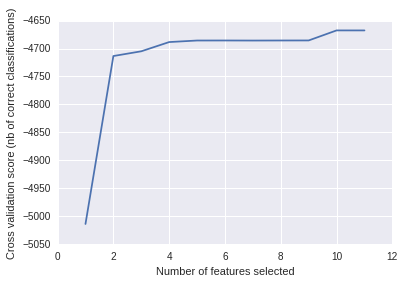

In [49]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show();

## Custom Recursive Feature Elimination

In [104]:
class CustomRFE(object):
    def __init__(self, est, scoring):
        self.est = est
        self.scoring = scoring
        
    def fit(self, X, y):
        # iteratively remove a single feature from the total feature set
        # store the rmse against the index of the feature removed from the feature set
        
        self.grid_scores = np.zeros(X.shape[1])
        features_to_remove = []
        
        for i in range(X.shape[1]):
            features_to_remove.append(i)
            X_ = np.delete(X.values, features_to_remove, axis=1)
            
            rmse = 0
            counter = 0
            
            cv = KFold(len(X_), n_folds=3)
            
            for train_index, test_index in cv:
                X_train, X_test = X_[train_index], X_[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                
                self.est.fit(X_train, y_train)
                y_pred = self.est.predict(X_test)
                
                rmse += -self.scoring(y_test, y_pred)
                counter += 1
                
            self.grid_scores[(X.shape[1] - len(features_to_remove))] = rmse / counter

In [105]:
rf_est = RandomForestRegressor(n_jobs=-1)
customrfe = CustomRFE(rf_est, scoring=scorer_func)
customrfe.fit(X, y)

In [106]:
customrfe.grid_scores

array([    0.        , -4806.08395604, -4489.1756411 , -2959.26927966,
       -2960.05538616, -2966.92485317, -2971.55619458, -3090.91403448,
       -3104.18072465, -3102.77552304, -2974.06797462])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X[X.columns[8:]], y, test_size=0.2, random_state=44)

In [110]:
rf_est.fit(X_train, y_train)
y_pred = rf_est.predict(X_test)
print('RMSE: ', scorer_func(y_test, y_pred))

RMSE:  2942.46255527


In [112]:
rf_est.fit(X[X.columns[8:]], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [118]:
preds = rf_est.predict(test_[X.columns[8:]])

In [120]:
sub['User_ID'] = test.User_ID.values
sub['Product_ID'] = test.Product_ID.values
sub['Purchase'] = preds

In [121]:
sub.to_csv('../submissions/rfecv.csv', index=False)